In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd

In [2]:
x=[]

with open("./GMM-data.txt", "r") as f:
    while True:
        line = f.readline()
        if not line:
            break
        line = line.replace("\n", "")
        line = list(map(float, line.split(" ")))
        x.append(line)
x = np.asarray(x)

Loading data from GMM-data.txt

In [3]:
class GaussianMixture(object):
    """Gaussian Mixture Model
    
    Classify datas into K classes.

    Usage example:
    >>> gmm = GaussianMixture(c=3)
    >>> gmm.fit_predict(x)
    """
    def __init__(self, c=2):
        """
        Args:
            c: number of classes to assgin datas
        Attributes:
            samples: Data to determine gaussian mixtures for
            mus: class means
            covs: class cvoariance matrices
            priors: class prior probabilites
            responsibilty_matrix: responsibility matrix in EM
            c: number of Gaussian components
            learned: Keeps track of if model has been fit
        """
        self.samples = np.nan
        self.mus = np.nan
        self.covs = np.nan
        self.priors = np.nan
        self.responsibility_matrix = np.nan
        self.c = c
        self.learned = False
        self.likelihood = 0


    def reset(self, c):
        """Resetting the parameters to inialized state."""
        self.samples = np.nan
        self.mus = np.nan
        self.covs = np.nan
        self.priors = np.nan
        self.c = c
        self.responsibility_matrix = np.nan
        self.learned = False
        self.likelihood = 0



    def fit(self, X):
        """Training function. Calculates the mean, covariance, priors of each distribution

        Calculate until the log-likelihood function converges.

        Args:
            X: Training data of shape[n_samples, n_features]
        Returns:
            an instance of self
        """
        self.samples = X
        n_samples = np.shape(X)[0]
        n_features = np.shape(X)[1]

        # Initialize mus, covs, priors
        initial_indices = np.random.choice(range(n_samples), self.c, replace=False)

        self.mus = X[initial_indices, :]
        self.covs = [np.identity(n_features) for i in range(self.c)]
        self.priors = [1.0/self.c for i in range(self.c)]

        count = 0
        # for iteration until it converges
        while True:
            count += 1
            new_likelihood = 0
            self.responsibility_matrix = self._expectation()
            self.priors, self.mus, self.covs = self._maximization()
            likelihood_prob = []
            for sample in self.samples:
                probabilities = [0 for i in range(self.c)]
                for k in range(self.c):
                    probability = multivariate_normal.pdf(sample, mean=self.mus[k], cov=self.covs[k]) * self.priors[k]
                    probabilities[k] = probability
                    
                sum_of_prob = sum(probabilities)
                likelihood_prob.append(np.log(sum_of_prob))
            
            new_likelihood = sum(likelihood_prob)

            if abs(new_likelihood - self.likelihood) < 1e-5:
                break

            else:
                self.likelihood = new_likelihood

        
        self.learned = True
        return self

    def _expectations(self, point):
        """The Expectation step of EM algorithm
        
        
        Args:
            point: The point to fit in the multivariate Gaussian function
        
        Returns:
            responsibilities: The responsibility value of the given point of each class.
        """
        responsibilities = [0 for i in range(self.c)]
        for k in range(self.c):
            probability = multivariate_normal.pdf(point,mean=self.mus[k], cov=self.covs[k]) * self.priors[k]
            responsibilities[k] = probability
        responsibilities = [float(i) / sum(responsibilities)
                            for i in responsibilities]
        return responsibilities

    def _expectation(self):
        """Applying the expectation calculation to the samples"""
        return np.apply_along_axis(self._expectations, 1, self.samples)

    def _maximization(self):
        """The Maximization step of EM algorithm
        
        Returns:
            priors: Updated value of priors that maximize the log-likelihood function
            mus: Updated value of means that maximize the log-likelihood function
            covs: Updated value of covariances that maximize the log-likelihood function
        """
        # Maximize priors
        priors = sum(self.responsibility_matrix)
        priors = [float(i)/sum(priors) for i in priors]

        # Maximize means
        mus = [0 for i in range(self.c)]
        for k in range(self.c):
            mus_k = sum(np.multiply(self.samples,
                                    self.responsibility_matrix[:, k][:, np.newaxis]))
            normalized_mus_k = mus_k / sum(self.responsibility_matrix[:, k])
            mus[k] = normalized_mus_k

        # Maximize covariances
        covs = [0 for i in range(self.c)]
        for k in range(self.c):
            x_mean_diff = self.samples - mus[k]
            x_mean_diff_res = np.multiply(x_mean_diff, self.responsibility_matrix[:,k][:,np.newaxis])

            cov = np.dot(x_mean_diff_res.T, x_mean_diff) / sum(self.responsibility_matrix[:, k])
            covs[k] = cov
            
        return priors, mus, covs

    def predict(self, x, probs=False):
        """The Discrimination step for given datas

        Args:
            x: Training data of shape[1, n_features]
            probs: if True, returns probability of each class as well
        Returns:
            float: Returns predicted class
        Raises:
            ValueError if model has not been fit
        """
        if not self.learned:
            raise NameError('Fit model first')

        probabilities = [0 for i in range(self.c)]
        for k in range(self.c):
            probability = multivariate_normal.pdf(x, mean=self.mus[k], cov=self.covs[k]) * self.priors[k]
            probabilities[k] = probability
        max_class = np.argmax(probabilities)
        class_probs = [float(i)/sum(probabilities) for i in probabilities]
        if probs:
            return (max_class, class_probs)
        return np.argmax(probabilities)


    def fit_predict(self, x):
        """The function to execute fitting and predict bothwise

        Args:
            x: Training data of shape[n_samples, n_features]

        Returns:
            value of predicted label for the given data in array type
        """
        pred = []
        self.fit(x)
        
        
        for data in x:
            pred.append(self.predict(data))

        return np.asarray(pred)

In [4]:
class GridSearch():
    """Class for GridSearch

    Finding the best K(number of class) for the GMM model, and plot the classified datas to find
    which is the best K

    Args:
        model: The GMM model
        param_grid: Dictionary type that contains the list of hyper parameters to calculate.

    Usage example:
        >>> model = GaussianMixture()
        >>> params = { 'k': [2,3,4,5] }
        >>> grid = GridSearch(model, params)
        >>> grid.fit(x)
        >>> grid.plot()
    """
    def __init__(self, model, param_grid):
        """
        Args:
            model: The GMM model to train
            param_grid: The list of parameters in the dictionary

        Attributes:
            model: The GMM model to train
            param_grid = The list of paramters in the dictionary
            classified = The list of dataframes that has been labeled.
        """
        self.model = model
        self.param_grid = param_grid
        self.classified = []
        
    def fit(self, x):
        """The training function itering the values of K that are given.

        Args:
            x: Training data of shape[n_samples, n_features]

        Returns: an instance of self

        Raises:
            ValueError if the minimum value of given K is smaller than 2
        """
        k_list = self.param_grid['k']

        if min(k_list) < 2:
            raise NameError("Minimum value of k should be larger than 2")
        
        for k in k_list:
            self.model.reset(k)
            pred = self.model.fit_predict(x)
            
            labled_data = {
                    'feature1': x[:,0],
                    'feature2': x[:,1],
                    'label': pred
                }

            labeled_df = pd.DataFrame(labled_data)
            
            self.classified.append(labeled_df)

        return self


    def plot(self):
        """Plotting fuction
        Plots the datas that are labeled. And discriminate the groups with color
        """

        n_fig = len(self.classified)
        
        fig, ax = plt.subplots(n_fig)
        fig.set_size_inches(3*n_fig,7*n_fig)
        
        for index, labeled in enumerate(self.classified):

            groups = labeled.groupby('label')

            num_of_k = labeled['label'].max() + 1
            
            
            for name, group in groups:
                ax[index].plot(
                    group.feature1,
                    group.feature2,
                    marker='o',
                    linestyle='',
                    label=name
                )

            ax[index].legend(fontsize=8, loc='upper left')
            ax[index].set_title("Scatter plot in grouped by GMM(k={0})".format(num_of_k), fontsize=20)
            ax[index].set_xlabel("Feature1")
            ax[index].set_ylabel('Feature2')

        plt.show()

In [5]:
parmas={
    'k' : [2,3,4,5]
}

In [6]:
model = GaussianMixture()
grid = GridSearch(model, parmas)

In [7]:
grid.fit(x)

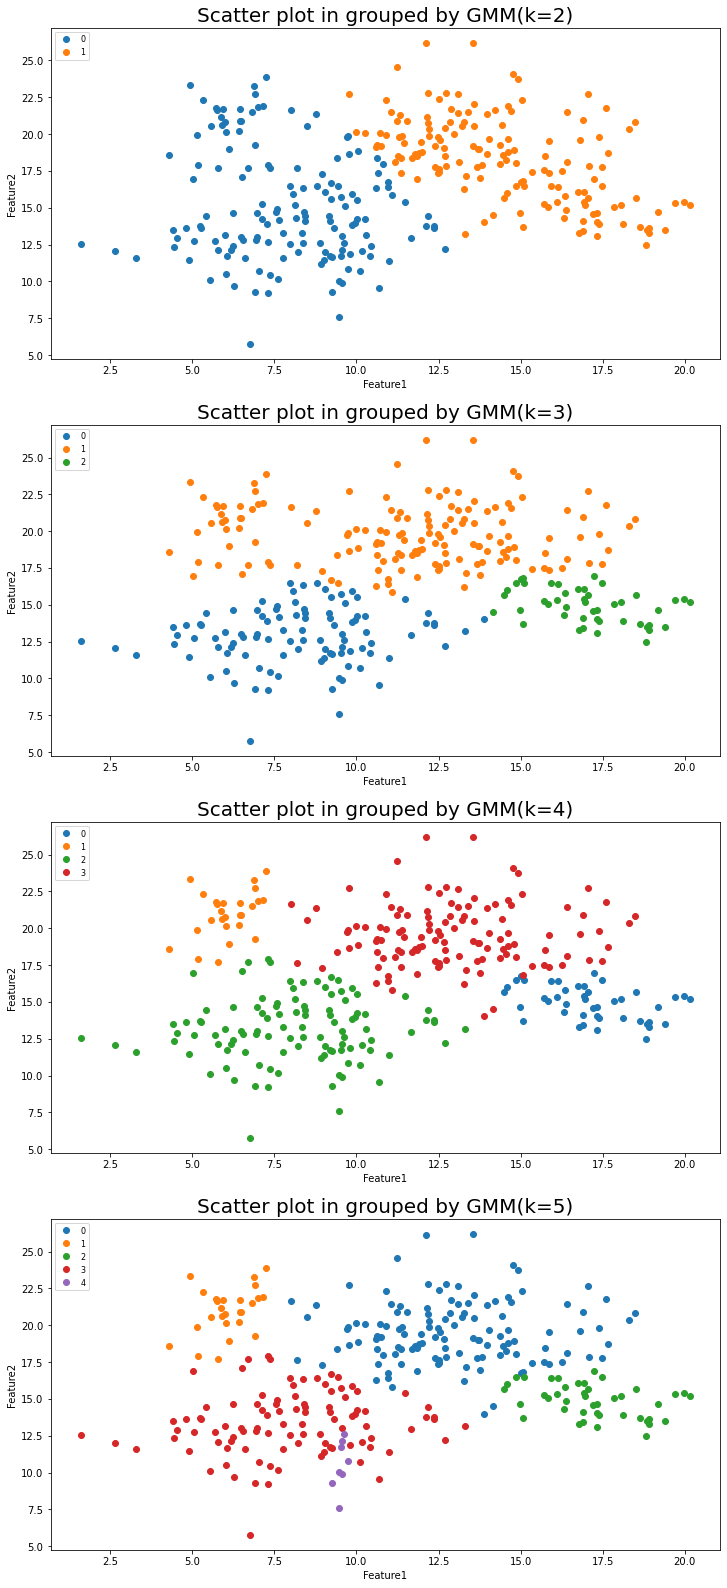

In [8]:
grid.plot()

By looking at the result above, it can be said that the best value for K is 3 or 4.<br>